In [1]:
import pyiron_workflow_atomistics.gb.gb_code.csl_generator as csl
from pyiron_workflow_atomistics.gb.gb_code.csl_generator import get_theta_m_n_list
import numpy as np
import pandas as pd
from math import degrees

from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes, get_gbcode_df
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode

from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize
from pyiron_workflow_lammps.engine import LammpsEngine
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.bulk import optimise_cubic_lattice_parameter
from ase.build import bulk


%load_ext autoreload
%autoreload 2

In [5]:
inp = CalcInputMinimize()
inp.relax_cell = False
Engine = LammpsEngine(EngineInput = inp)

Engine.working_directory = "test_opt_cubic_cell"
Engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
Engine.lammps_log_filepath = "minimize.log"
Engine.input_script_pair_style = "eam/fs"
Engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Fe_eam.fs"

structure = bulk("Fe", a=2.828, cubic=True)
wf1 = Workflow(Engine.working_directory, delete_existing_savefiles=True)
wf1.opt_cubic_cell = optimise_cubic_lattice_parameter(
    structure=structure,
    name="Fe",
    crystalstructure="bcc",
    calculation_engine=Engine,
    parent_working_directory="opt_cubic_cell",
    rattle=0.1,
    strain_range=(-0.02, 0.02),
    num_points=6,
)
wf1.run()

2025-07-31 01:05:26,550 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_000' already exists. Existing files may be overwritten.


calc_fn_kwargs (get_working_subdir_kwargs):
Inputs ['calc_structure_fn_kwargs', 'base_working_directory', 'new_working_directory']
OutputsWithInjection ['dict_with_adjusted_working_directory']
InputSignals ['run', 'accumulate_and_run']
OutputSignals ['ran', 'failed']
current mode  minimize
test_opt_cubic_cell


{'opt_cubic_cell__equil_struct': Atoms(symbols='Fe2', pbc=True, cell=[2.8433589311227556, 2.8433589311227556, 2.8433589311227556], initial_magmoms=...),
 'opt_cubic_cell__a0': 2.8433589311227556,
 'opt_cubic_cell__B': 181.5261997670728,
 'opt_cubic_cell__equil_energy_per_atom': -4.021690053738244,
 'opt_cubic_cell__equil_volume_per_atom': 11.493837774345888,
 'opt_cubic_cell__volumes': [21.287097162601995,
  21.81268105404494,
  22.346845717919777,
  22.889660634165235,
  23.441195282719992,
  24.001519143522813],
 'opt_cubic_cell__structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.77144, 1.6970175625144705e-16, 1.6970175625144705e-16], [0.0, 2.77144, 1.6970175625144705e-16], [0.0, 0.0, 2.77144]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.794064, 1.7108707671064253e-16, 1.7108707671064253e-16], [0.0, 2.794064, 1.7108707671064253e-16], [0.0, 0.0, 2.794064]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.816688, 1.72472397169838e-16, 1.72472397169838e-16], [0.0, 2.816688, 1.724723971698

In [7]:
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes
gbcode_df = get_gbcode_df_multiple_axes(axes_list=[np.array([1, 1, 1]), np.array([1, 1, 0]), np.array([1, 0, 0])],
                   basis="bcc",
                   sigma_limit=100,
                   lim_plane_index=3,
                   lattice_param=wf1.opt_cubic_cell.outputs.a0.value,
                   max_atoms=2000,
                   remove_duplicates=True,
                   max_search_duplicate_atoms_limit=200,
                   max_workers=None,
                   equil_volume_per_atom=wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value)
from pyiron_workflow_atomistics.gb.gb_code.searcher import _deduplicate_gbcode_df_miller_indices_equivalent

gbcode_df_unique = _deduplicate_gbcode_df_miller_indices_equivalent(gbcode_df)
gbcode_df_unique

Processing all axes: 100%|██████████| 3/3 [02:02<00:00, 40.82s/it] 


,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe
0,"[1, 1, 1]",3,3,1,"(-1, 1, 0)","(-1, 0, 1)",60.000000,Tilt,12,"((-1, -1, 0), (-1, 0, -1))",False
2,"[1, 1, 1]",3,3,1,"(1, 1, 1)","(1, 1, 1)",60.000000,Twist,12,"((-1, -1, -1), (-1, -1, -1))",False
7,"[1, 1, 1]",3,3,1,"(1, 0, 2)","(2, 0, 1)",60.000000,Mixed,180,"((-2, -1, 0), (-1, -2, 0))",False
8,"[1, 1, 1]",3,3,1,"(-1, 2, -1)","(-2, 1, 1)",60.000000,Symmetric Tilt,12,"((-2, -1, -1), (-1, -2, 1))",False
10,"[1, 1, 1]",3,3,1,"(2, 0, 1)","(2, 1, 0)",60.000000,Mixed,180,"((-2, -1, 0), (-2, 0, -1))",False
...,...,...,...,...,...,...,...,...,...,...,...
2042,"[1, 0, 0]",89,13,3,"(0, -13, 3)","(0, -13, -3)",25.989234,Symmetric Tilt,712,"((-13, -3, 0), (-13, 3, 0))",False
2046,"[1, 0, 0]",89,13,3,"(0, 2, -21)","(0, 11, -18)",25.989234,Tilt,1780,"((-21, -2, 0), (-18, -11, 0))",False
2054,"[1, 0, 0]",97,13,5,"(0, 9, 4)","(0, 4, 9)",42.075022,Symmetric Tilt,388,"((-9, -4, 0), (-4, -9, 0))",False
2060,"[1, 0, 0]",97,13,5,"(0, -5, -13)","(0, 5, -13)",42.075022,Symmetric Tilt,776,"((-13, -5, 0), (-13, 5, 0))",False


In [15]:
gbcode_df_unique.sort_values(by="n_atoms")
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_with_structures
gbcode_df_unique_structures = get_gbcode_df_with_structures(df=gbcode_df_unique,
                                                            basis="bcc",
                                                            lattice_param=wf1.opt_cubic_cell.outputs.a0.value,
                                                            equil_volume_per_atom=wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                                                            req_length_grain=15,
                                                            min_inplane_gb_length=8,
                                                            grain_length_axis=0,
                                                            element="Fe",
                                                            max_workers=None)
gbcode_df_unique_structures

,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe,structure,structure_natoms
0,"[1, 1, 1]",3,3,1,"(-1, 1, 0)","(-1, 0, 1)",60.000000,Tilt,12,"((-1, -1, 0), (-1, 0, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",384
2,"[1, 1, 1]",3,3,1,"(1, 1, 1)","(1, 1, 1)",60.000000,Twist,12,"((-1, -1, -1), (-1, -1, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",336
7,"[1, 1, 1]",3,3,1,"(1, 0, 2)","(2, 0, 1)",60.000000,Mixed,180,"((-2, -1, 0), (-1, -2, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534
8,"[1, 1, 1]",3,3,1,"(-1, 2, -1)","(-2, 1, 1)",60.000000,Symmetric Tilt,12,"((-2, -1, -1), (-1, -2, 1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",288
10,"[1, 1, 1]",3,3,1,"(2, 0, 1)","(2, 1, 0)",60.000000,Mixed,180,"((-2, -1, 0), (-2, 0, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,"[1, 0, 0]",89,13,3,"(0, -13, 3)","(0, -13, -3)",25.989234,Symmetric Tilt,712,"((-13, -3, 0), (-13, 3, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",2100
2046,"[1, 0, 0]",89,13,3,"(0, 2, -21)","(0, 11, -18)",25.989234,Tilt,1780,"((-21, -2, 0), (-18, -11, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",5334
2054,"[1, 0, 0]",97,13,5,"(0, 9, 4)","(0, 4, 9)",42.075022,Symmetric Tilt,388,"((-9, -4, 0), (-4, -9, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",1140
2060,"[1, 0, 0]",97,13,5,"(0, -5, -13)","(0, 5, -13)",42.075022,Symmetric Tilt,776,"((-13, -5, 0), (-13, 5, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",2292


In [16]:
import numpy as np
import pandas as pd

# assume your DataFrame is called gbcode_df_unique_structures


def lattice_lengths(atoms):
    # get the 3×3 cell matrix
    cell = atoms.get_cell()        # or atoms.cell
    # length of each lattice vector
    return np.linalg.norm(cell[0]), np.linalg.norm(cell[1]), np.linalg.norm(cell[2])

# apply to the structure column and expand into a,b,c
gbcode_df_unique_structures[['a','b','c']] = gbcode_df_unique_structures['structure'] \
    .apply(lambda at: pd.Series(lattice_lengths(at), index=['a','b','c']))

# now df has columns a, b, c alongside everything else
gbcode_df_unique_structures

,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe,structure,structure_natoms,a,b,c
0,"[1, 1, 1]",3,3,1,"(-1, 1, 0)","(-1, 0, 1)",60.000000,Tilt,12,"((-1, -1, 0), (-1, 0, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",384,9.849684,13.929557,32.168934
2,"[1, 1, 1]",3,3,1,"(1, 1, 1)","(1, 1, 1)",60.000000,Twist,12,"((-1, -1, -1), (-1, -1, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",336,8.042234,13.929557,34.473895
7,"[1, 1, 1]",3,3,1,"(1, 0, 2)","(2, 0, 1)",60.000000,Mixed,180,"((-2, -1, 0), (-1, -2, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.530077,19.073832,37.723800
8,"[1, 1, 1]",3,3,1,"(-1, 2, -1)","(-2, 1, 1)",60.000000,Symmetric Tilt,12,"((-2, -1, -1), (-1, -2, 1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",288,9.849684,8.042234,41.788671
10,"[1, 1, 1]",3,3,1,"(2, 0, 1)","(2, 1, 0)",60.000000,Mixed,180,"((-2, -1, 0), (-2, 0, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.530077,19.073832,37.723800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,"[1, 0, 0]",89,13,3,"(0, -13, 3)","(0, -13, -3)",25.989234,Symmetric Tilt,712,"((-13, -3, 0), (-13, 3, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",2100,8.530077,37.935140,74.591567
2046,"[1, 0, 0]",89,13,3,"(0, 2, -21)","(0, 11, -18)",25.989234,Tilt,1780,"((-21, -2, 0), (-18, -11, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",5334,8.530077,59.980722,119.826657
2054,"[1, 0, 0]",97,13,5,"(0, 9, 4)","(0, 4, 9)",42.075022,Symmetric Tilt,388,"((-9, -4, 0), (-4, -9, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",1140,8.530077,28.003838,54.852878
2060,"[1, 0, 0]",97,13,5,"(0, -5, -13)","(0, 5, -13)",42.075022,Symmetric Tilt,776,"((-13, -5, 0), (-13, 5, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",2292,8.530077,39.603407,77.981967


current mode  minimize
test_opt_cubic_cell
test_opt_cubic_cell
In get_length executing
test_opt_cubic_cell/gb_length_optimiser
In get_length executing
test_opt_cubic_cell/gb_length_optimiser
In get_gb_length_optimiser_plot executing
test_opt_cubic_cell/gb_length_optimiser
In get_gb_length_optimiser_plot executing
In generate_deepcopy executing
In get_gb_length_optimiser_plot executing
double peak detected
32 63


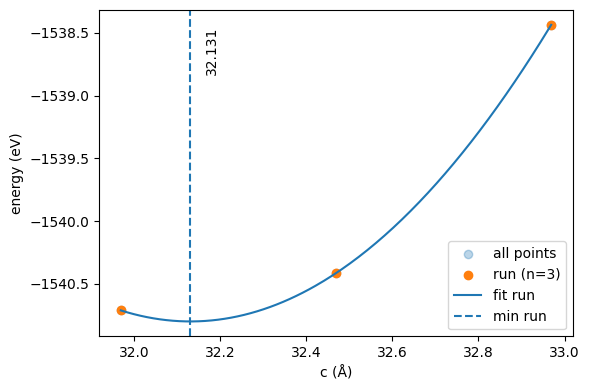

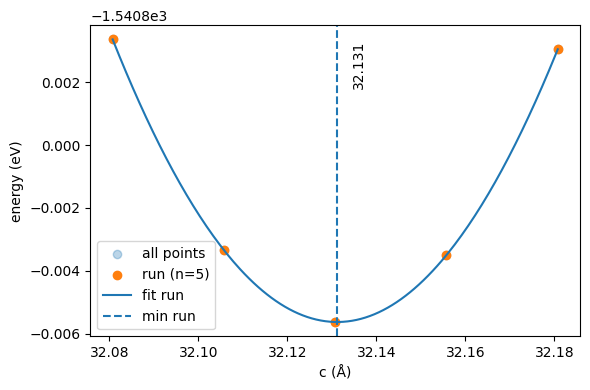

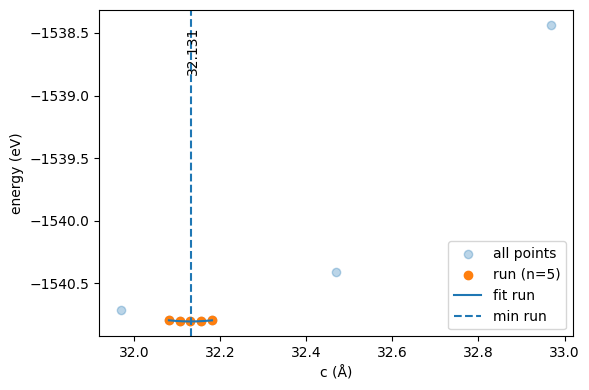

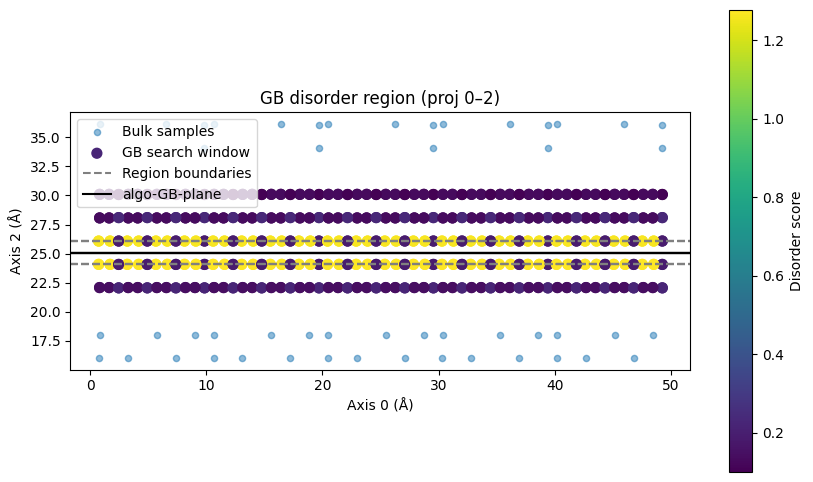

test_opt_cubic_cell/cleavage_study
test_opt_cubic_cell/cleavage_study
test_opt_cubic_cell/cleavage_study/cleavage_rigid
test_opt_cubic_cell/cleavage_study/cleavage_relax


FailedChildError: /pure_gb_study encountered error in child: {'/pure_gb_study/cleavage_study.accumulate_and_run': FailedChildError('/pure_gb_study/cleavage_study encountered multiple errors in children: {\'/pure_gb_study/cleavage_study/calc_cleavage_rigid.accumulate_and_run\': FailedChildError("/pure_gb_study/cleavage_study/calc_cleavage_rigid encountered error in child: {\'/pure_gb_study/cleavage_study/calc_cleavage_rigid/cleave_setup.accumulate_and_run\': RuntimeError(\'No atoms found within tol=0.3 of c=25.073711153032896.\')}"), \'/pure_gb_study/cleavage_study/calc_cleavage_relax.accumulate_and_run\': FailedChildError("/pure_gb_study/cleavage_study/calc_cleavage_relax encountered error in child: {\'/pure_gb_study/cleavage_study/calc_cleavage_relax/cleave_setup.accumulate_and_run\': RuntimeError(\'No atoms found within tol=0.3 of c=25.073711153032896.\')}")}')}

In [20]:
from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize, CalcInputStatic
gb_study_list = []
for _, row in gbcode_df_unique_structures.head(5).iterrows():
    inp = CalcInputMinimize()
    inp.relax_cell = False
    Engine = LammpsEngine(EngineInput = inp)
    Engine.working_directory = "test_opt_cubic_cell"
    Engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
    Engine.lammps_log_filepath = "minimize.log"
    Engine.input_script_pair_style = "eam/fs"
    Engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Fe_eam.fs"
    
    gb_opt_engine_static = LammpsEngine(EngineInput=CalcInputStatic())
    gb_opt_engine_static.working_directory = "pure_gb_study"
    gb_opt_engine_static.command = "/root/github_dev/lammps/build/lmp -in in.lmp -log static.log"
    gb_opt_engine_static.lammps_log_filepath = "static.log"
    gb_opt_engine_static.path_to_model = "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model"
    from pyiron_workflow_atomistics.gb.gb_study import pure_gb_study
    from pyiron_workflow_atomistics.gb.dataclass_storage import CleaveGBStructureInput, PlotCleaveInput
    from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
    gb_study = pure_gb_study(
                    gb_structure = row["structure"],
                    equil_bulk_volume = wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                    equil_bulk_energy = wf1.opt_cubic_cell.outputs.equil_energy_per_atom.value,
                    extensions_stage1 = np.linspace(-0.2, 0.8, 3),
                    extensions_stage2 = np.linspace(-0.05, 0.05, 5),
                    calculation_engine = Engine,
                    static_calculation_engine = Engine,
                    length_interpolate_min_n_points=5,
                    gb_normal_axis="c",
                    vacuum_length=20,
                    min_inplane_cell_lengths=[6, 6, None],
                    featuriser = voronoiSiteFeaturiser,
                    approx_frac = 0.5,
                    tolerance = 5.0,
                    bulk_offset = 10.0,
                    slab_thickness = 2.0,
                    featuriser_kwargs = None,
                    n_bulk = 10,
                    threshold_frac = 0.3,
                    CleaveGBStructure_Input=CleaveGBStructureInput(),
                    PlotCleave_Input=PlotCleaveInput())()
    
    gb_study_list.append(gb_study)


In [ ]:
FailedChildError: /pure_gb_study/cleavage_study encountered multiple errors in children: {'/pure_gb_study/cleavage_study/calc_cleavage_rigid.accumulate_and_run': FailedChildError("/pure_gb_study/cleavage_study/calc_cleavage_rigid encountered error in child: {'/pure_gb_study/cleavage_study/calc_cleavage_rigid/cleave_setup.accumulate_and_run': RuntimeError('No atoms found within tol=0.3 of c=25.073711153032896.')}"), '/pure_gb_study/cleavage_study/calc_cleavage_relax.accumulate_and_run': FailedChildError("/pure_gb_study/cleavage_study/calc_cleavage_relax encountered error in child: {'/pure_gb_study/cleavage_study/calc_cleavage_relax/cleave_setup.accumulate_and_run': RuntimeError('No atoms found within tol=0.3 of c=25.073711153032896

In [17]:
gbcode_df_unique_structures.sort_values(by="structure_natoms")

,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe,structure,structure_natoms,a,b,c
1247,"[1, 1, 0]",17,3,2,"(3, -3, 4)","(3, -3, -4)",86.627713,Symmetric Tilt,136,"((-4, -3, -3), (-4, 3, 3))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",264,8.042234,11.723469,32.183714
281,"[1, 1, 1]",7,5,1,"(0, 1, 3)","(1, 0, 3)",38.213211,Mixed,140,"((-3, -1, 0), (-3, 0, -1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",276,10.638875,8.410769,35.452162
1037,"[1, 1, 0]",9,4,1,"(-2, 2, -1)","(-2, 2, 1)",38.942441,Symmetric Tilt,72,"((-2, -2, -1), (-2, -2, 1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",280,8.042234,12.063350,33.172521
812,"[1, 1, 0]",3,2,1,"(0, 0, -3)","(-2, 2, -1)",70.528779,Tilt,72,"((-3, 0, 0), (-1, -2, -2))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",284,8.042234,12.063350,33.646414
814,"[1, 1, 0]",3,2,1,"(0, -3, 3)","(1, -4, -1)",70.528779,Mixed,72,"((-4, -1, -1), (-3, 0, 3))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",284,8.042234,8.530077,47.583215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,"[1, 1, 0]",27,5,1,"(-5, 0, -1)","(-5, 0, 1)",31.586338,Mixed,1404,"((-5, -1, 0), (-5, 1, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",5588,14.774526,75.335598,57.704230
1912,"[1, 0, 0]",37,6,1,"(0, -16, 15)","(0, -20, 9)",18.924644,Tilt,1924,"((-20, -9, 0), (-16, -15, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",5760,8.530077,62.359730,124.460168
2064,"[1, 0, 0]",97,13,5,"(0, 22, -1)","(0, 17, 14)",42.075022,Tilt,1940,"((-22, -1, 0), (-17, 14, 0))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",5808,8.530077,62.618485,124.978749
539,"[1, 1, 1]",21,9,1,"(-9, 13, -4)","(-12, 11, 1)",21.786789,Tilt,1596,"((-13, -9, -4), (-11, -12, 1))",False,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",6360,9.849684,80.321744,92.398886


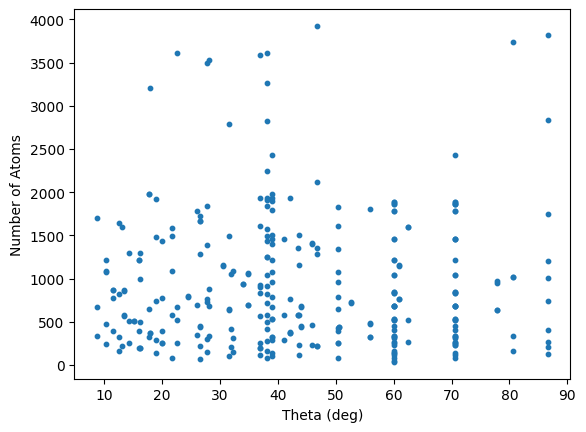

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(gbcode_df_unique["Theta (deg)"], gbcode_df_unique["n_atoms"], s=10)
plt.xlabel("Theta (deg)")
plt.ylabel("Number of Atoms")
plt.show()

In [ ]:
all_gb_df = _construct_gbcode_structures_from_df(
            df=all_gb_df,
            basis=basis,
            lattice_param=lattice_param,
            equil_volume_per_atom=equil_volume_per_atom,
            max_workers=max_workers
        )